# BCG - TASK 3

## Sub-Task 1:

- Your colleague has done some work on engineering the features within the cleaned dataset and has calculated a feature which seems to have predictive power. 

- This feature is “the difference between off-peak prices in December and January the preceding year”. 



## 1. Importing Required Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize']=[15,12]

## 2. Reading the Dataset

In [2]:
data = pd.read_csv('Cleaned_EDA_Data_Task2.csv')
data.head(2)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,44.26693,40.565969,40.942265,24.43733,0.0,22.35201,16.291555,0.0,14.90134,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,44.44471,44.266930,44.311375,0.00000,0.0,0.00000,0.000000,0.0,0.00000,0


In [3]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
data.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean,churn
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,44.26693,40.565969,40.942265,24.43733,0.0,22.35201,16.291555,0.0,14.90134,1
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,44.44471,44.266930,44.311375,0.00000,0.0,0.00000,0.000000,0.0,0.00000,0


## 3. Feature Engineering:

### Difference between off-peak prices in December and preceding January

- Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power

In [5]:
client_data = pd.read_csv('client_data.csv')

In [6]:
price_data = pd.read_csv('price_data.csv')
price_data["price_date"] = pd.to_datetime(price_data["price_date"], format='%Y-%m-%d')
price_data.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_data.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 
                                                                    'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(

    dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), 
    jan_prices.drop(columns='price_date'), on='id'
)
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]

diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


- Check whether changes in prices would affect customer churn (only considering off peak prices)

- Among the cutomers whose off-peak enery prices increased, around 9.72% of customers changed their providers.

In [8]:
stat_ = ['max', 'min', 'mean']
price_attr = ['price_off_peak_var','price_peak_var','price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']
price_stat = price_data.drop(columns=['price_date']).groupby(['id']).agg({'price_off_peak_var': stat_, 'price_peak_var': stat_, 'price_mid_peak_var': stat_,
                                                      'price_off_peak_fix': stat_, 'price_peak_fix': stat_, 'price_mid_peak_fix': stat_,})
# flatten the column names
price_stat.columns = ['_'.join(x) for x in zip(price_stat.columns.get_level_values(0), price_stat.columns.get_level_values(1))]
price_stat = price_stat.reset_index()
price_stat.head(3)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_peak_var_max,price_peak_var_min,price_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_mid_peak_var_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.119906,0.124338,0.105842,0.101673,0.103794,0.073773,0.070232,0.07316,40.728885,40.565969,40.701732,24.43733,24.339581,24.421038,16.291555,16.226389,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.143943,0.146426,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.444710,44.266931,44.385450,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.150837,0.181558,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,45.944710,44.444710,45.319710,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
def plot_bar_chart_with_percent_label(df, target_variable, if_sort=False, gap_label_bar=0, figsize=(9,6)):
    # prepare data
    plot_data = client_data[[target_variable]].value_counts().reset_index(name='count')
    plot_data['percent'] = plot_data['count']/plot_data['count'].sum()
    if if_sort:
        x_order = plot_data.sort_values(by=['percent'], ascending=False)[target_variable]
    else:
        x_order = plot_data.sort_values(by=[target_variable], ascending=True)[target_variable]
    # plot
    fig = plt.figure(figsize=figsize)
    ax = sns.barplot(data=plot_data, x=target_variable, y='percent', order=x_order)
    # add label
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + gap_label_bar
        ax.annotate(text='{:.2f}%'.format(p.get_height()*100), xy=(x, y), ha='center')
    ax.margins(y=0.1)

In [10]:
# add diff
for attr in price_attr:
    price_stat[f'diff_Dec_mean_{attr}'] = price_data[price_data['id'].isin(price_stat['id'])].groupby(['id'])[attr].nth(-1).values - price_stat[f'{attr}_mean']
#
price_stat.head(3)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_peak_var_max,price_peak_var_min,price_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_mid_peak_var_mean,...,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.119906,0.124338,0.105842,0.101673,0.103794,0.073773,0.070232,0.07316,...,24.421038,16.291555,16.226389,16.280694,-0.004432,-0.002121,0.000559,0.027153,0.016292,0.010861
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.143943,0.146426,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,-0.002483,0.000000,0.000000,0.059260,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.150837,0.181558,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.019722,0.000000,0.000000,0.625000,0.000000,0.000000


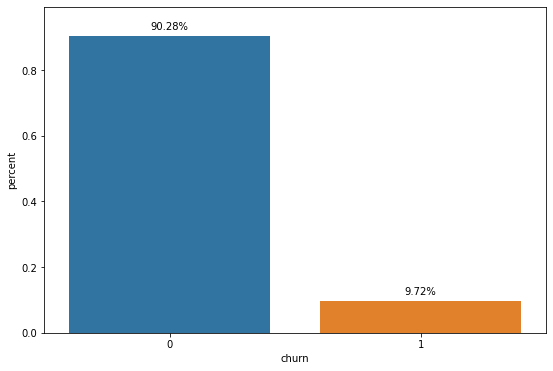

In [11]:
plot_bar_chart_with_percent_label(df=price_stat[price_stat['diff_Dec_mean_price_off_peak_var']>0], target_variable='churn', gap_label_bar=0.02)

#### OBSERVATION:
- Among the cutomers whose off-peak energy prices did not increase (decreased or did not change), also around 9.72% of customers changed their providers.

In [12]:
price_stat_3_month = price_data[price_data['price_date']>'2015-09-01'].drop(columns=['price_date']).groupby(['id']).agg({'price_off_peak_var': stat_, 'price_off_peak_fix': stat_,})
# flatten the column names
price_stat_3_month.columns = ['_'.join(x) for x in zip(price_stat_3_month.columns.get_level_values(0), price_stat_3_month.columns.get_level_values(1))]
price_stat_3_month = price_stat_3_month.reset_index()
# add churn values
price_stat_3_month = price_stat_3_month.merge(client_data[['id','churn']], on=['id'], how='left')
# drop ids that are not inclued in the price dataset 
price_stat_3_month = price_stat_3_month.dropna(subset=['churn']).reset_index(drop=True)
# add diff
for attr in ['price_off_peak_var','price_off_peak_fix']:
    price_stat_3_month[f'diff_Dec_mean_{attr}'] = price_data[price_data['id'].isin(price_stat_3_month['id'])].groupby(['id'])[attr].nth(-1).values - price_stat_3_month[f'{attr}_mean']
price_stat_3_month.head(5)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,churn,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.119906,0.119906,40.728885,40.728885,40.728885,0.0,0.0,0.000000e+00
1,0004351ebdd665e6ee664792efc4fd13,0.143943,0.143943,0.143943,44.444710,44.444710,44.444710,0.0,0.0,7.105427e-15
2,0010bcc39e42b3c2131ed2ce55246e3c,0.201280,0.201280,0.201280,45.944710,45.944710,45.944710,0.0,0.0,7.105427e-15
3,00114d74e963e47177db89bc70108537,0.145440,0.145440,0.145440,44.266930,44.266930,44.266930,0.0,0.0,0.000000e+00
4,0013f326a839a2f6ad87a1859952d227,0.121647,0.121647,0.121647,40.728885,40.728885,40.728885,0.0,0.0,0.000000e+00


- If only considering the last 3 months, changes in prices did not affect customer churn either

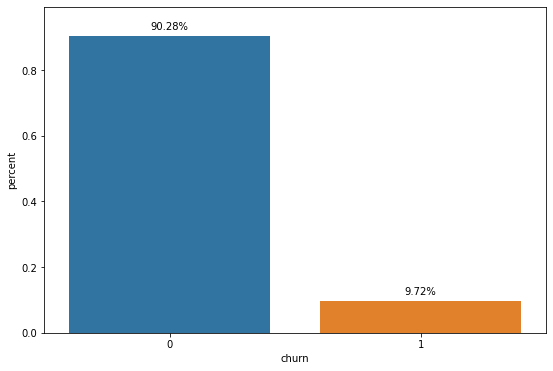

In [13]:
plot_bar_chart_with_percent_label(df=price_stat_3_month[price_stat_3_month['diff_Dec_mean_price_off_peak_var']>0], target_variable='churn', gap_label_bar=0.02)

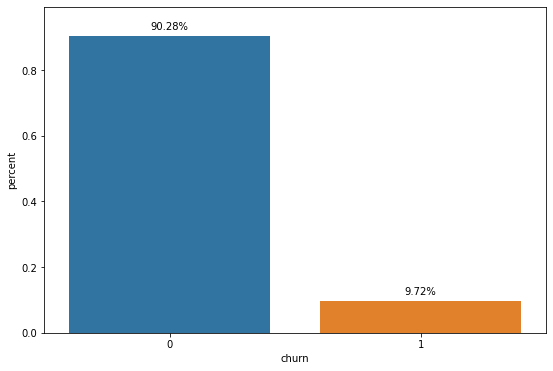

In [14]:
plot_bar_chart_with_percent_label(df=price_stat_3_month[price_stat_3_month['diff_Dec_mean_price_off_peak_var']<=0], target_variable='churn', gap_label_bar=0.02)

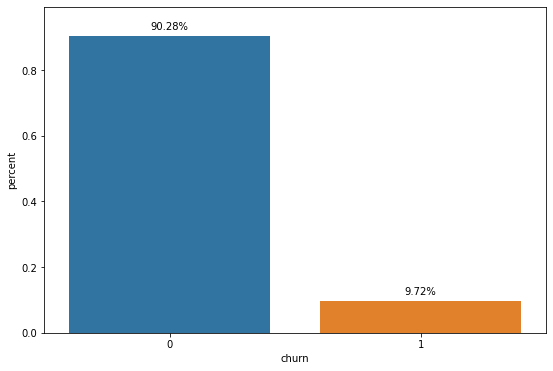

In [15]:
plot_bar_chart_with_percent_label(df=price_stat_3_month[price_stat_3_month['diff_Dec_mean_price_off_peak_fix']>0], target_variable='churn', gap_label_bar=0.02)

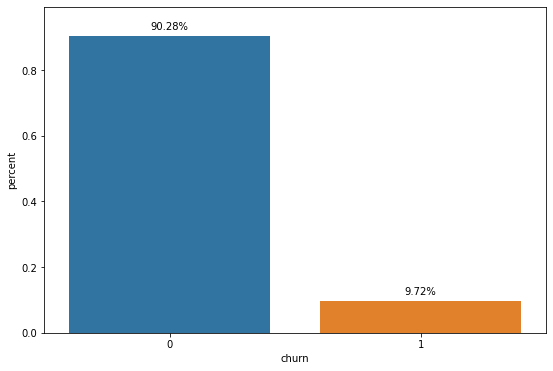

In [16]:
plot_bar_chart_with_percent_label(df=price_stat_3_month[price_stat_3_month['diff_Dec_mean_price_off_peak_fix']<=0], target_variable='churn', gap_label_bar=0.02)

#### OBSERVATION:
- From all results above, we can conclude customers were not sensitive to prices.
- In an effort to consider the viewpoint of a PowerCo client, its believed that calculating the maximum price change across months and time periods(January) would be a useful feature to develop. 
- The significant price increase within a short period of time would prompt me to shop around for a better deal with other utilities providers. 
- For this use case, we are attempting to predict churn, thus I thought it would be interesting to integrate this feature.


In [17]:
print("\n ----- Statistical Summary of Skewed ----- \n")
data.describe().T


 ----- Statistical Summary of Skewed ----- 



,count,mean,std,min,25%,50%,75%,max
channel_sales,14606.0,3.266945,2.183223,0.0,0.000000,4.000000,4.000000,7.000000e+00
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.750000,14115.500000,40763.750000,6.207104e+06
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.000000,792.500000,3383.000000,7.712030e+05
forecast_cons_12m,14606.0,1868.614880,2387.571531,0.0,494.995000,1112.875000,2401.790000,8.290283e+04
forecast_cons_year,14606.0,1399.762906,3247.786255,0.0,0.000000,314.000000,1745.750000,1.753750e+05
forecast_discount_energy,14606.0,0.966726,5.108289,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14606.0,63.086871,66.165783,0.0,16.180000,18.795000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14606.0,0.137283,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14606.0,0.050491,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01


In [18]:
correlation = data.corr()

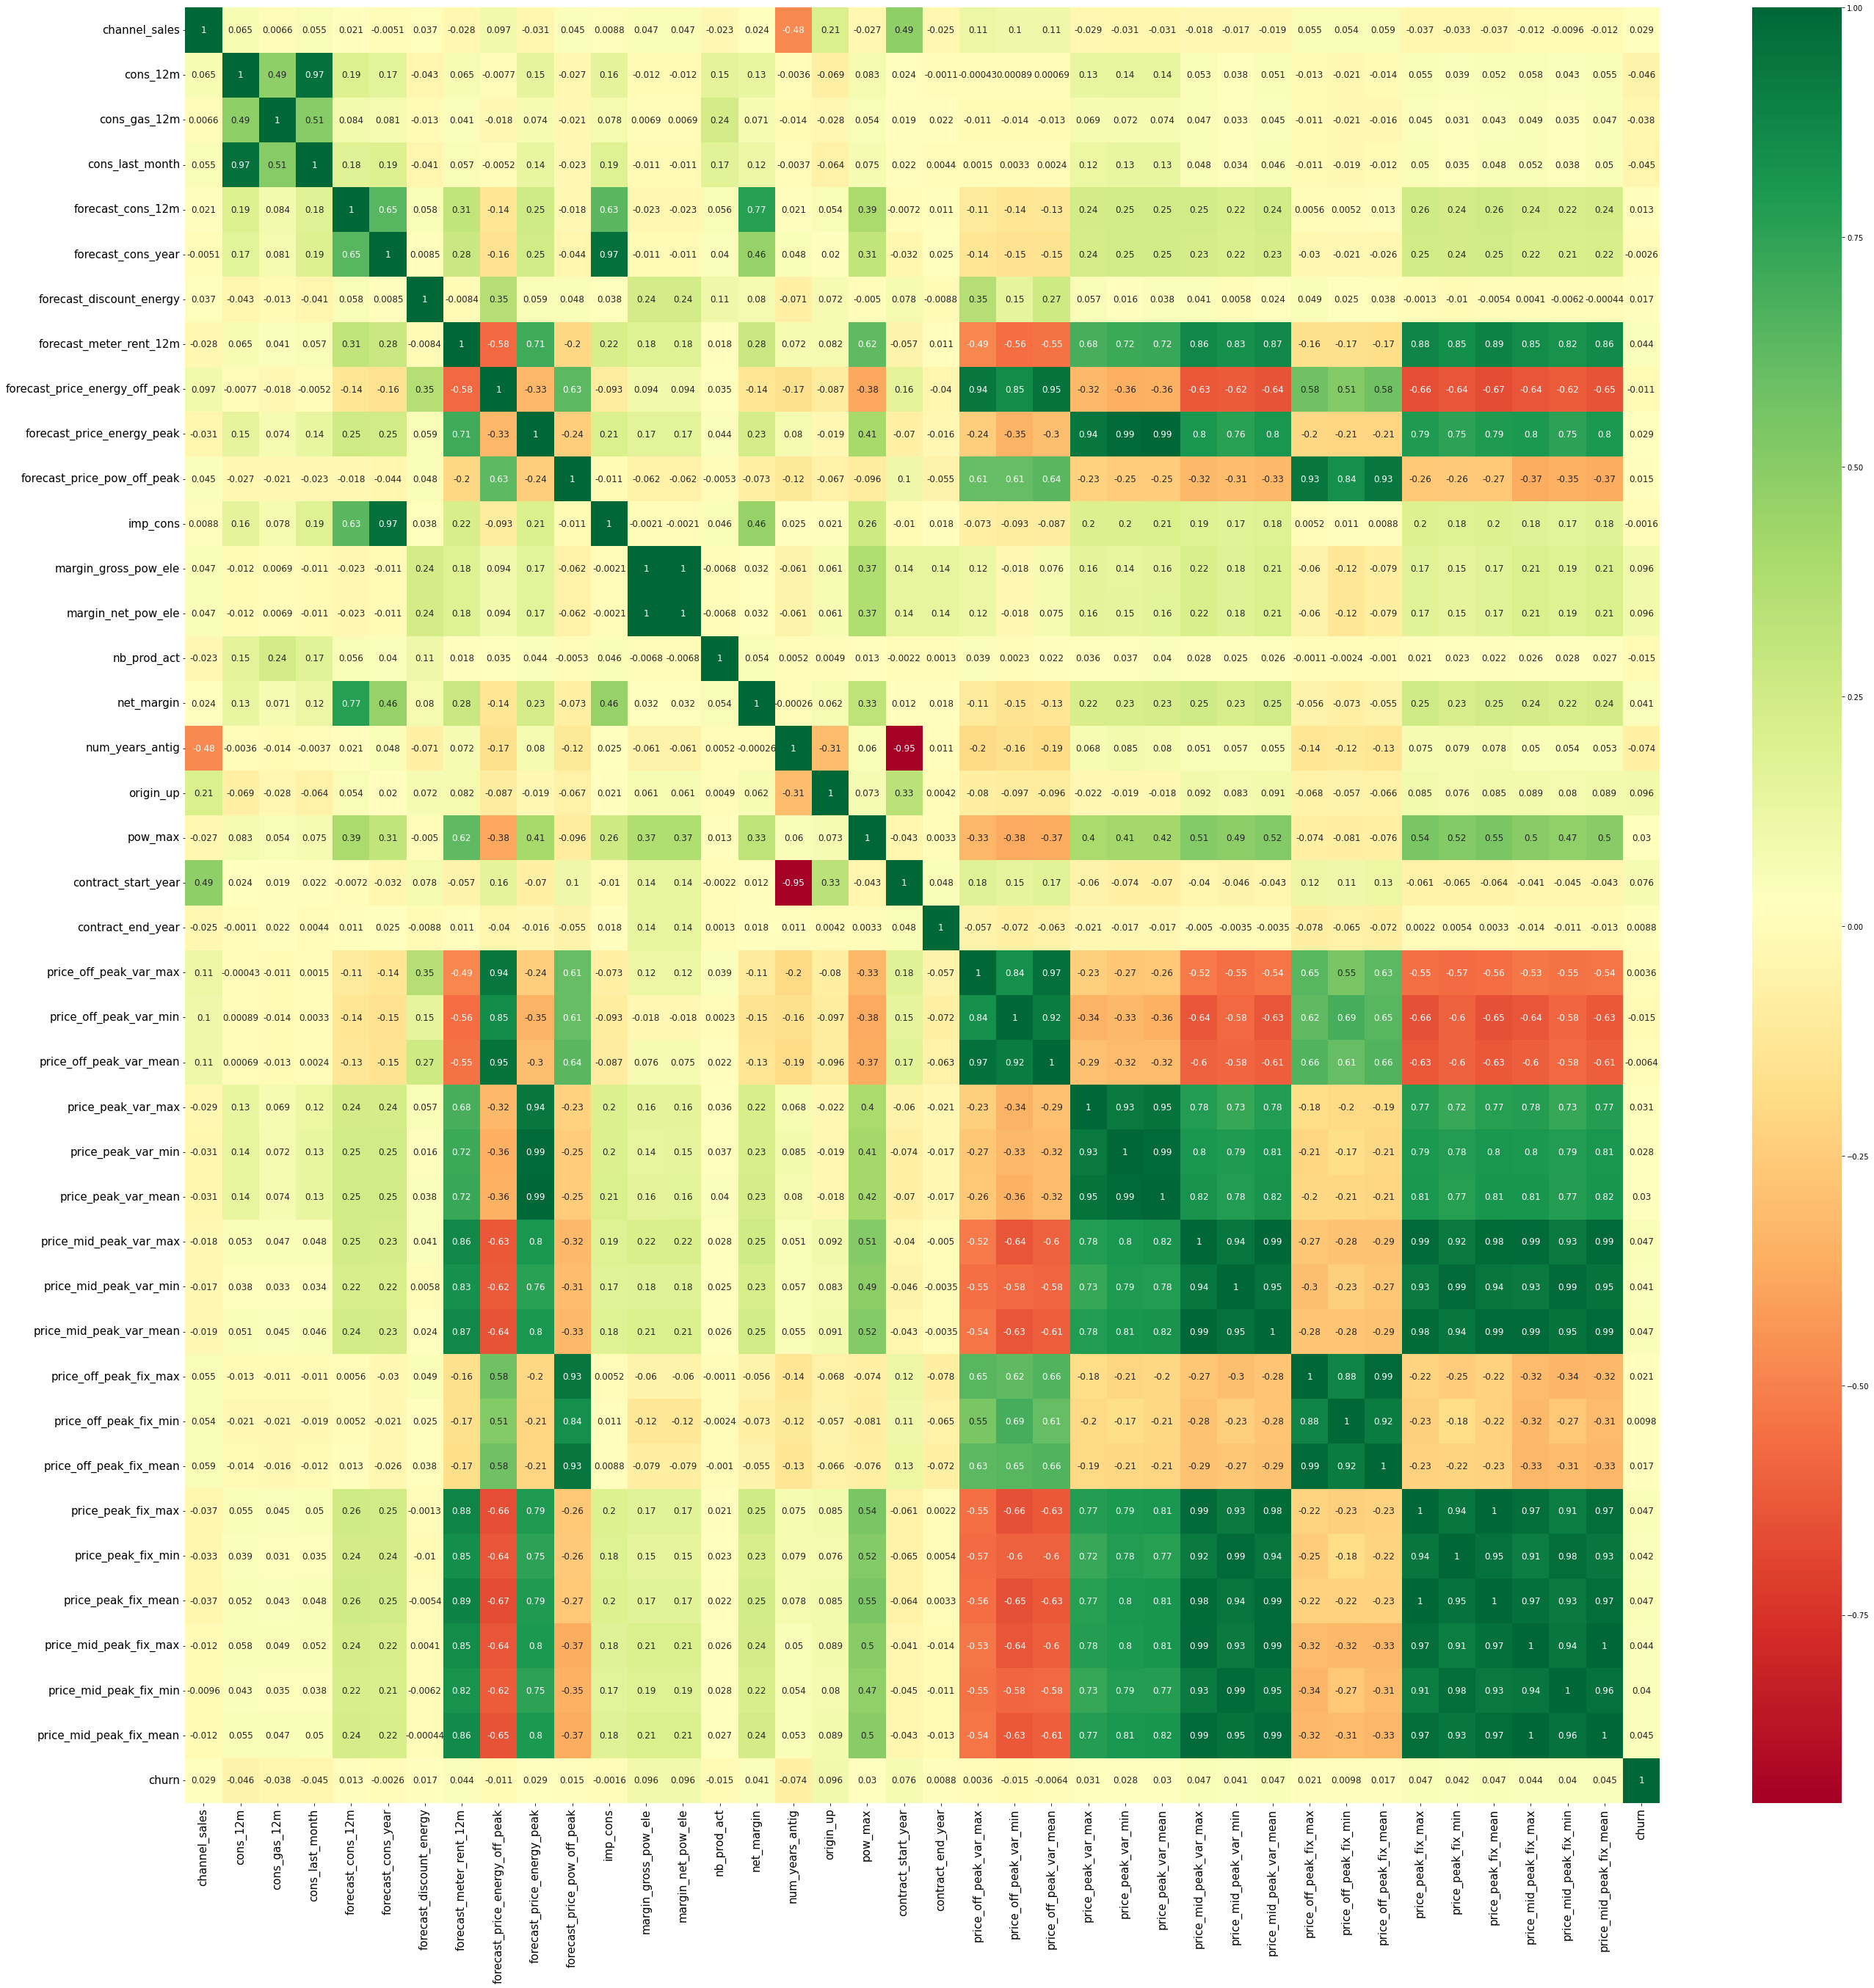

In [19]:
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}, 
    cmap='RdYlGn'
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# View of graph
plt.show()

#### OBSERVATIONS:


## Sub-Task 2:

##### Now that you have a dataset of cleaned and engineered features, it is time to build a predictive model to see how well these features are able to predict a customer churning. It is your task to train a Random Forest classifier and to evaluate the results in an appropriate manner.

* SUGGESTED MODEL: Random Forest, below points to complete the  work:

1. Is this problem best represented as classification or regression? 
2. What kind of model performance do you think is appropriate? 
3. Most importantly how would you measure such a performance? 
4. How would you tie business metrics such as profits or savings to the model performance?


# Feature Engineering

In [20]:
client_data['channel_sales'] = client_data['channel_sales'].astype('category')

# Let's see how many categories are within this column
print("\n ----- Value Counts of Channel Sales ----- \n")
client_data['channel_sales'].value_counts()


 ----- Value Counts of Channel Sales ----- 



foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [21]:
client_data = pd.get_dummies(client_data, columns=['channel_sales'], prefix='channel')
client_data = client_data.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 
                                  'channel_epumfxlbckeskwekxbiuasklxalciiuu', 
                                  'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
client_data.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,net_margin,num_years_antig,origin_up,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,1,0,0,0,0


In [22]:
# Transform into categorical type
client_data['origin_up'] = client_data['origin_up'].astype('category')

# Let's see how many categories are within this column
print("\n ----- Value Counts of Origin Up ----- \n")
client_data['origin_up'].value_counts()


 ----- Value Counts of Origin Up ----- 



lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [23]:
client_data = pd.get_dummies(client_data, columns=['origin_up'], prefix='origin_up')
client_data = client_data.drop(columns=['origin_up_MISSING', 
                      'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 
                      'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
client_data.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,43.648,1,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,13.800,0,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,13.856,0,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,13.200,0,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,19.800,0,1,0,0,0,0,1,0,0


#### OBSERVATIONS:

1. We have 8 categories, so we will create 8 dummy variables from channel_sales column. However, as we can see the last 3 categories in the output above, shows that they only have 11, 3 and 2 occurrences respectively. For this reason, we will drop these 3 dummy variables.
2.  Similar to channel_sales the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [24]:
client_data.skew()

cons_12m                                       5.997308
cons_gas_12m                                   9.597530
cons_last_month                                6.391407
forecast_cons_12m                              7.155853
forecast_cons_year                            16.587990
forecast_discount_energy                       5.155098
forecast_meter_rent_12m                        1.505148
forecast_price_energy_off_peak                -0.119586
forecast_price_energy_peak                    -0.014331
forecast_price_pow_off_peak                   -4.998772
imp_cons                                      13.198799
margin_gross_pow_ele                           4.472632
margin_net_pow_ele                             4.473326
nb_prod_act                                    8.636878
net_margin                                    36.569515
num_years_antig                                1.446214
pow_max                                        5.786785
churn                                          2

* We can see that the standard deviation for most of these features is quite high.

In [25]:
client_data["cons_12m"] = np.log10(client_data["cons_12m"] + 1)
client_data["cons_gas_12m"] = np.log10(client_data["cons_gas_12m"] + 1)
client_data["cons_last_month"] = np.log10(client_data["cons_last_month"] + 1)
client_data["forecast_cons_12m"] = np.log10(client_data["forecast_cons_12m"] + 1)
client_data["forecast_cons_year"] = np.log10(client_data["forecast_cons_year"] + 1)
client_data["forecast_meter_rent_12m"] = np.log10(client_data["forecast_meter_rent_12m"] + 1)
client_data["imp_cons"] = np.log10(client_data["imp_cons"] + 1)

In [26]:
client_data = client_data.drop(columns=['num_years_antig', 'forecast_cons_year'])

In [27]:
remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

client_data = client_data.drop(columns=remove)
client_data.head(2)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.0,0.00000,0.0,0.444045,0.114481,0.098142,40.606701,...,43.648,1,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.0,2.28092,0.0,1.237292,0.145711,0.000000,44.311378,...,13.800,0,1,0,0,0,0,1,0,0


In [28]:
client_data['has_gas'] = client_data['has_gas'].replace(['t', 'f'], [1, 0])
client_data.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


## Train-Test Split:

In [29]:
# Make a copy of our data
train_df = client_data.copy()

# Separate target variable from independent variables
X = client_data.drop(columns=['id', 'churn'])
y = client_data['churn']

In [30]:
X.head(2)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,net_margin,pow_max,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0.000000,4.739944,0.0,0.00000,0.0,0.444045,0.114481,0.098142,40.606701,1,...,678.99,43.648,0,0,1,0,0,0,0,1
1,3.668479,0.000000,0.0,2.28092,0.0,1.237292,0.145711,0.000000,44.311378,0,...,18.89,13.800,1,0,0,0,0,1,0,0


In [31]:
print(X.shape)
print(y.shape)

(14606, 24)
(14606,)


In [32]:
## Split data into train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 24)
(10954,)
(3652, 24)
(3652,)


# Building a Model

In [34]:
# fit all the models at once

clfs = {
    'Logreg' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Ada Boost' : AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'XgBoost' : XGBClassifier(),
}

models_report = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'roc auc', 'f1 score'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Fitting model...', clf_name)
    t = {'model name' : clf_name,
        'accuracy' : accuracy_score(y_test,y_pred),
        'recall' : recall_score(y_test,y_pred),
        'precision' : precision_score(y_test,y_pred),
        'roc auc' : roc_auc_score(y_test,y_pred),
        'f1 score' : f1_score(y_test,y_pred),
        }
    models_report = models_report.append(t, ignore_index=True)

models_report = models_report.sort_values(by='accuracy', ascending=False)
models_report

Fitting model... Logreg
Fitting model... KNN
Fitting model... Naive Bayes
Fitting model... Decision Tree
Fitting model... Random Forest
Fitting model... Ada Boost
Fitting model... Gradient Boost
Fitting model... XgBoost


,model name,accuracy,recall,precision,roc auc,f1 score
4,Random Forest,0.901972,0.035519,0.722222,0.516999,0.067708
7,XgBoost,0.900876,0.068306,0.543478,0.530958,0.121359
6,Gradient Boost,0.900055,0.008197,0.600000,0.503794,0.016173
0,Logreg,0.899507,0.005464,0.400000,0.502276,0.010782
5,Ada Boost,0.899507,0.002732,0.333333,0.501062,0.005420
1,KNN,0.891840,0.027322,0.204082,0.507727,0.048193
2,Naive Bayes,0.832968,0.112022,0.125767,0.512645,0.118497
3,Decision Tree,0.832694,0.196721,0.185090,0.550126,0.190728


### OBSERVATIONS:

1. From the fit check code for all the algorithms for the train data, it is observed that random forest has highest accuracy as required for the task.
2. Eventually with the highest Precision with 0.7  


## RANDOM FOREST CLASSIFIER

1. Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems

2. The random forest algorithm is an extension of the bagging method as it utilizes both bagging and feature randomness to create an uncorrelated forest of decision trees.

3. Random forest algorithms have three main hyperparameters, which need to be set before training.

4. The random forest classifier can be used to solve for regression or classification problems.


BENEFITS:
1. Reduced risk of overfitting
2. Provides flexibility
3. Easy to determine feature importance

CHALLENGES:
1. Time-consuming process
2. Requires more resources
3. More complex

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)

## Model prediction on X_test data

In [36]:
## prediction of test data
y_pred = rf_classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Model Evaluation

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:- ", accuracy)
print("\n ----- Classification Report ----- \n")
print(classification_report(y_test, y_pred))

Accuracy score:-  0.9025191675794085

 ----- Classification Report ----- 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.81      0.04      0.07       366

    accuracy                           0.90      3652
   macro avg       0.86      0.52      0.51      3652
weighted avg       0.89      0.90      0.86      3652



### Confusion Matrix

[[3283    3]
 [ 353   13]]


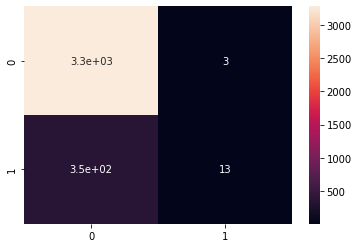

In [38]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True)
plt.show()

### ROC-AUC Curve

In [39]:
auc = roc_auc_score(y_test, y_pred)
print("AUC score:- ", auc)

AUC score:-  0.5173030807964905


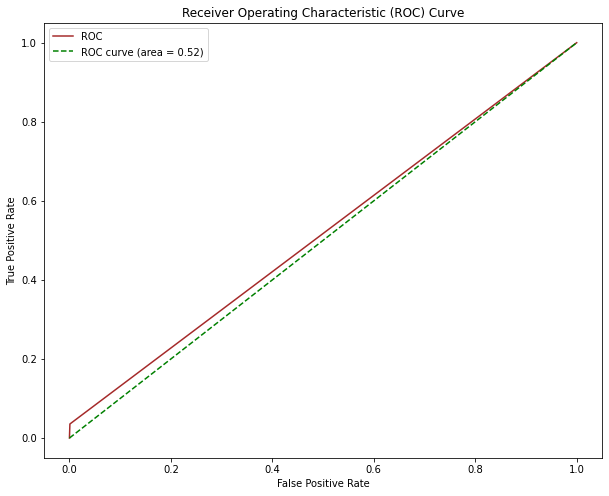

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='brown', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### K-Fold Cross Validation

In [41]:
# Applying 5-Fold Cross Validation

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))

Cross-validation scores:[0.90597901 0.90780466 0.90689183 0.90597901 0.90730594]


### Average cross-validation score:

In [50]:
print('Average cross-validation score: {:.4f}'.format(cv_scores.mean()))

Average cross-validation score: 0.9068


### Model Understanding - Feature Importances

In [43]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

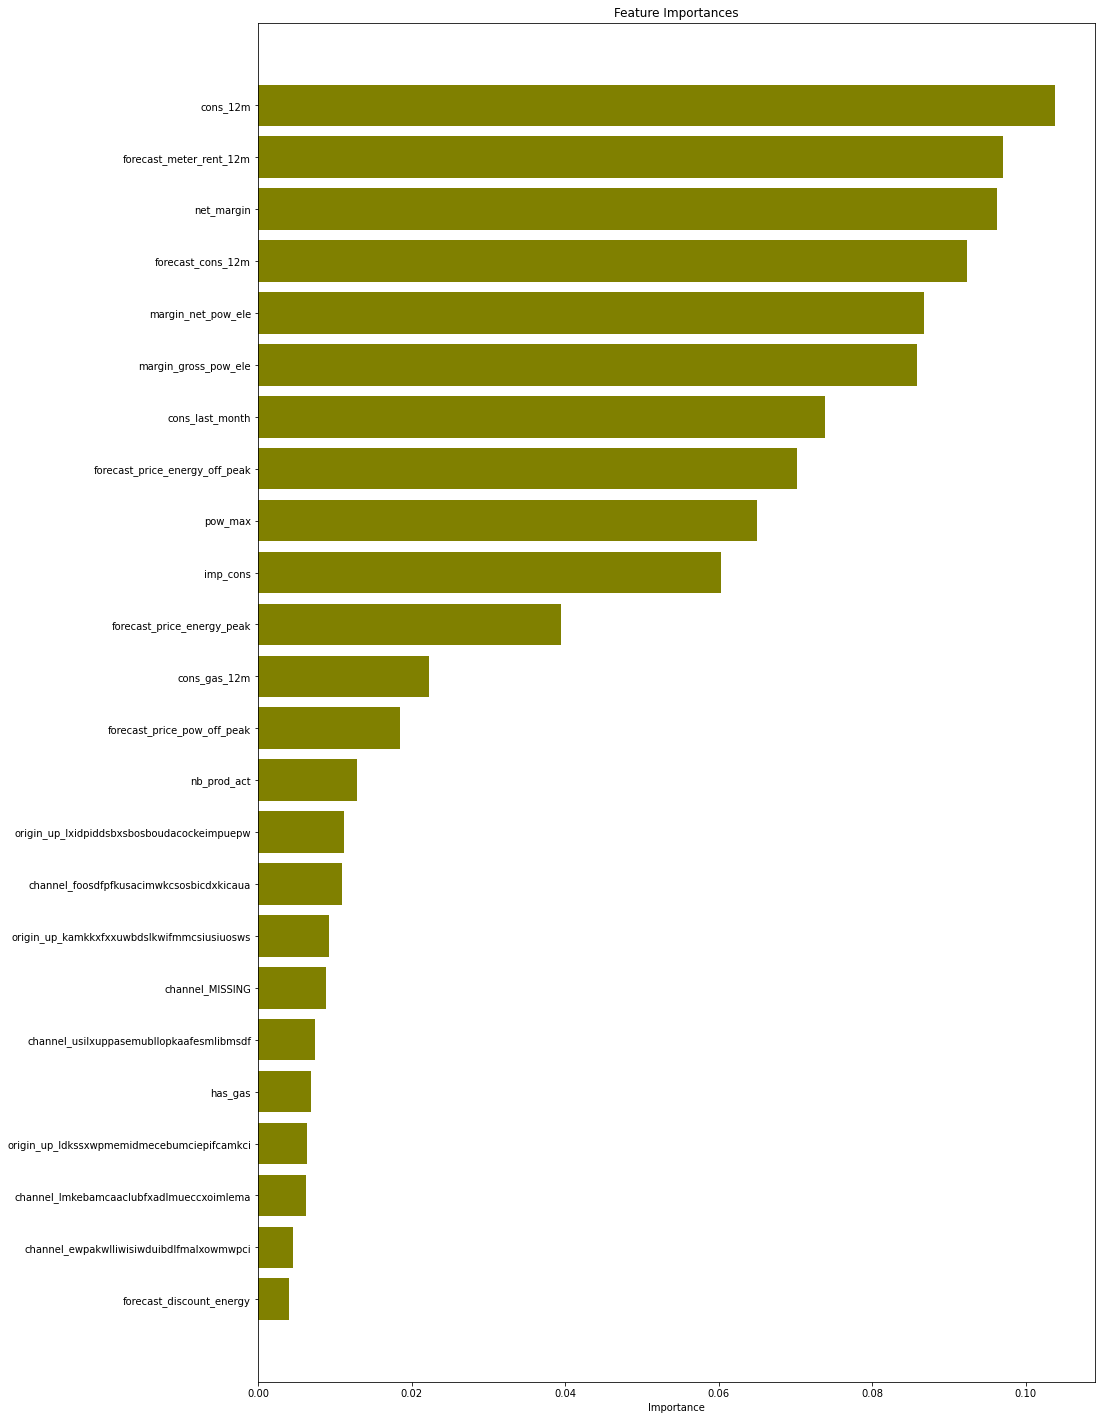

In [44]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='olive', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

#### OBSETVATIONS:
#### From this chart, we can observe the following points:

1. Net margin on power subscription and consumption over 12 months is a top driver for churn in this model
2. The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
3. Our price sensitivity features are scattered around but are not the main driver for a customer churning

#### The last observation is important because this relates back to our original hypothesis:

> Is churn driven by the customers' price sensitivity?



#### Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [45]:
proba_predictions = rf_classifier.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [46]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

##### Final file 

In [47]:

X_test['churn'] = y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('predicted_data.csv')

## Bonus Task

* Relate the model performance to the client's financial performance with the introduction of the discount proposition. How much money could a client save with the use of the model? What assumptions did you make to come to this conclusion?

**Bonus task: identify the impact of a 20% discount
This is a tricky problem.**

First, intuitively, we have concluded that changes in prices do not have a significant impact on customer churn. So, a discount should be unable to prevent customer churn.
second, we cannot really identify whether a discount can prevent customer churn, as we do not exactly know what will happen in the future.
Therefore, I try to calculate the expected profit based on the probability of customer churn and evaluate the impact of the discount.

### Workflow:
Our task is to calculate the forecast revenue for the set of customers:

1. When no discount is offered
2. And when a discount is offered based on a probability cutoff to decide who should receive the 20% discount

And hence to decide where the cut-off should be set in order to maximise revenue

In [65]:
test_data = pd.read_csv('predicted_data.csv')
test_data.drop(test_data.columns[0], axis=1, inplace=True)
test_data.head(2)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,4.173390,4.193598,3.165541,3.168368,0.0,2.073828,0.114667,0.099548,40.606701,1,...,0,0,1,0,0,0,0,1,0,0.073
1,4.075036,0.000000,3.003461,3.305998,30.0,1.255031,0.198096,0.000000,46.305378,0,...,0,0,1,0,0,0,0,1,0,0.119


### Calculating a baseline revenue estimate (no intervention)
Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast price and actual churn outcome. Call this basecase_revenue.

* For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable basecase_revenue_after_churn, ie basecase_revenue_after_churn = basecase_revenue(1 -0.919 churn)

In [56]:

# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step

test_data['basecase_revenue'] = (np.power(10, test_data['forecast_cons_12m']) + 1) * test_data['forecast_price_energy_off_peak'] + test_data['forecast_meter_rent_12m']

# Taking churn into account
test_data['basecase_revenue_after_churn'] = test_data['basecase_revenue'] * (1 - 0.919 * test_data['churn'])

In [66]:
test_data.head(2)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,4.173390,4.193598,3.165541,3.168368,0.0,2.073828,0.114667,0.099548,40.606701,1,...,0,0,1,0,0,0,0,1,0,0.073
1,4.075036,0.000000,3.003461,3.305998,30.0,1.255031,0.198096,0.000000,46.305378,0,...,0,0,1,0,0,0,0,1,0,0.119


### Calculate the estimated benefits and costs of intervention
Now, pick a cut-off probability (eg 0.5) so that:

* Customers with a higher churn probability than the cut-off get a discount, and
* Customers below the churn-probability do not get a discount.

**From this, calculate the revenue of the intervention scenario assuming:**
* All customers who are offered a discount accept it
* Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability = 0), and therefore the retained revenue is 0.8basecase_revenue , being (1-discount_fraction)basecase_revenue

* Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph. What cut-off probability approximately optimises the revenue outcome? Assume for these calculations that the customer does not consume more or less electricity because the price changes. In practice, we would expect that if the customer's cost goes down then their consumption might increase. We will see two counterbalancing effects at play:

* For true positives we will see revenue retention vs the no-discount scenario
* For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn.

In [58]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

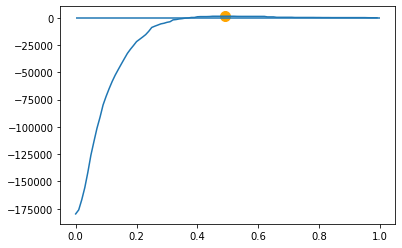

Maximum benefit at cutoff 0.49 with revenue delta of $1,375.42


In [59]:

# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='orange')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)

### Optional extra: how to select the cut-off?
Above, we decided who to offer the discount to based on a probability cut-off. Is this the optimal strategy?

* For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.
* Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and prioritise customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

In [60]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2, min_rev: float=500):
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[(pred['churn_probability'] >= cutoff) & (pred['basecase_revenue'] > min_rev),
    'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

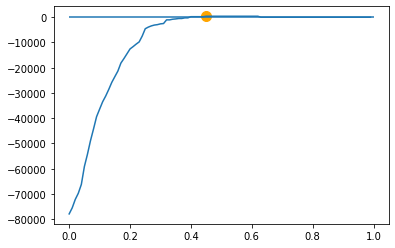

Maximum benefit at cutoff 0.45 with revenue delta of $396.02


In [61]:
## Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

### Optional extra: Using forecast rather than actual churn
We may have noticed above that we used actual churn outcomes in calculating the financial impact. Actual churn outcomes are fine if we know them and are conducting a retrospective analysis of the effectiveness of a strategy. This example of analysis is commonly known as "backtesting", ie seeing how well a strategy would have performed historically.

Of course, one must be careful that any analysis is done using out-of-sample data. Conducting the analysis on the training data will lead to predictions that are too optimistic.

In practice, actual outcomes may not be available because they are in the future. An alternative is to optimise predicted/forecast revenue based on the probabilities which are an output from our churn model. In this case, we would replace the actual churn outcomes (churn) with the predicted probability of churn from our model. The results here are obviously model-dependent.

If our model probabilities are poorly calibrated then we can end up with quite poor results from this. Going down this path therefore usually requires the extra step of checking how well calibrated the model probabilities are, and potentially correcting for any miscalibration using Platt scaling, sigmoid calibration or isotonic regression.

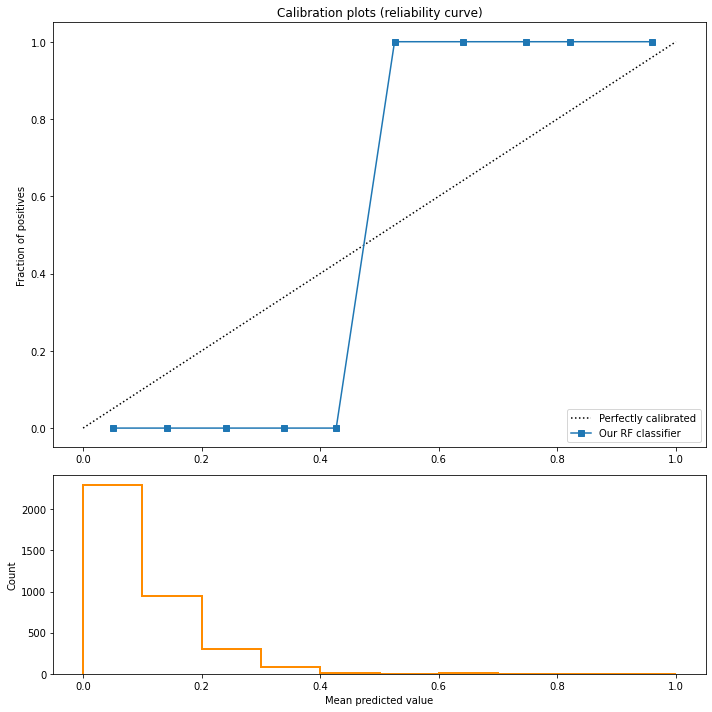

In [62]:
# Check our calibration

from sklearn.calibration import calibration_curve

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true=test_data['churn'],
    y_prob=test_data['churn_probability'],
    n_bins=10
)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Our RF classifier")
ax2.hist(test_data['churn_probability'], range=(0, 1), bins=10, color='darkorange', histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
plt.tight_layout()

#### OBSERVATIONS:

This chart tells us a few things:
1. The top calibration curve exhibits a sigmoid curve, which is typical for an under-confident classifier.
2. The bottom chart shows us that the model is postively skewed toward predicting a probability, perhaps due to having such low confidence.

In [63]:
# Electricity evenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more d
# Note that we need to reverse the log10-transformation from the data cleaning step

test_data['basecase_revenue'] = np.power(10, test_data['forecast_cons_12m']) * test_data['forecast_price_energy_off_peak'] + test_data['forecast_meter_rent_12m']
# Taking churn into account
test_data['basecase_revenue_after_churn'] = test_data['basecase_revenue'] * (1 - 0.919 * test_data['churn_probability'])

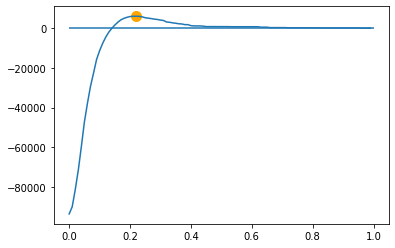

Maximum benefit at cutoff 0.22 with revenue delta of $6,040.46


In [64]:

# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas)
